In [1]:
import json

In [2]:
import json
import os
from collections import defaultdict

def get_ground_truth(image_path):
    """
    Determines the correct class based on the file path.
    Returns specific labels for cat, dog, wolf, and fox.
    """
    path_lower = image_path.lower()
    
    if 'cat' in path_lower:
        return 'cat'
    elif 'dog' in path_lower:
        return 'dog'
    elif 'wolf' in path_lower:
        return 'wolf'
    elif 'fox' in path_lower:
        return 'fox'
    elif "tiger" in path_lower:
        return "tiger"
    else:
        return 'unknown'

def main():
    file_path = "./results/experiment/experiment_results.jsonl"
    
    # Dictionary to store stats for aggregation
    # Key: class_name, Value: list of dicts with values
    aggregated_data = defaultdict(lambda: {
        'count': 0,
        'cnn_cat': 0.0, 'cnn_dog': 0.0,
        'inf_cat': 0.0, 'inf_dog': 0.0,
        'diff_cat': 0.0, 'diff_dog': 0.0
    })
    
    # Define column headers and width
    # Structure: Class | CNN (cat/dog) | Inferred (cat/dog) | Diff (cat/dog)
    header = f"{'Ground Truth Class':<20} | {'CNN (cat/dog)':<18} | {'Inferred (cat/dog)':<18} | {'Diff (cat/dog)':<18}"
    separator = "-" * len(header)
    
    print(separator)
    print(header)
    print(separator)

    try:
        with open(file_path, 'r') as f:
            for line in f:
                if not line.strip():
                    continue
                    
                entry = json.loads(line)
                image_path = entry.get('image_path', 'Unknown')
                
                # 1. Analyze image_path to get animal type
                true_label = get_ground_truth(image_path)
                
                if true_label == 'unknown':
                    continue

                # Extract Probabilities
                cnn_cat = entry['cnn_probabilities'].get('cat', 0.0)
                cnn_dog = entry['cnn_probabilities'].get('dog', 0.0)
                
                inf_cat = entry['inferred_probabilities'].get('cat', 0.0)
                inf_dog = entry['inferred_probabilities'].get('dog', 0.0)
                
                # Calculate Differences (Inferred - CNN)
                diff_cat = inf_cat - cnn_cat
                diff_dog = inf_dog - cnn_dog
                
                # Accumulate data
                stats = aggregated_data[true_label]
                stats['count'] += 1
                stats['cnn_cat'] += cnn_cat
                stats['cnn_dog'] += cnn_dog
                stats['inf_cat'] += inf_cat
                stats['inf_dog'] += inf_dog
                stats['diff_cat'] += diff_cat
                stats['diff_dog'] += diff_dog

        # Process and print averages
        # Sort keys to ensure consistent order (e.g., cat, dog, fox, wolf)
        for label in sorted(aggregated_data.keys()):
            stats = aggregated_data[label]
            count = stats['count']
            
            if count == 0:
                continue
                
            # Calculate averages
            avg_cnn_cat = stats['cnn_cat'] / count
            avg_cnn_dog = stats['cnn_dog'] / count
            avg_inf_cat = stats['inf_cat'] / count
            avg_inf_dog = stats['inf_dog'] / count
            avg_diff_cat = stats['diff_cat'] / count
            avg_diff_dog = stats['diff_dog'] / count
            
            # Format strings for columns
            col_class = f"{label.capitalize()} (n={count})"
            col_cnn = f"{avg_cnn_cat:.3f} / {avg_cnn_dog:.3f}"
            col_inf = f"{avg_inf_cat:.3f} / {avg_inf_dog:.3f}"
            col_diff = f"{avg_diff_cat:+.3f} / {avg_diff_dog:+.3f}"
            
            print(f"{col_class:<20} | {col_cnn:<18} | {col_inf:<18} | {col_diff:<18}")

        print(separator)

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except json.JSONDecodeError:
        print(f"Error: Failed to decode JSON from '{file_path}'.")

if __name__ == "__main__":
    main()

-----------------------------------------------------------------------------------
Ground Truth Class   | CNN (cat/dog)      | Inferred (cat/dog) | Diff (cat/dog)    
-----------------------------------------------------------------------------------
Cat (n=15)           | 0.994 / 0.006      | 0.874 / 0.126      | -0.120 / +0.120   
Dog (n=15)           | 0.357 / 0.643      | 0.403 / 0.597      | +0.046 / -0.046   
Fox (n=12)           | 0.717 / 0.283      | 0.795 / 0.205      | +0.078 / -0.078   
Tiger (n=12)         | 0.893 / 0.107      | 0.665 / 0.335      | -0.228 / +0.228   
Wolf (n=12)          | 0.461 / 0.539      | 0.063 / 0.937      | -0.398 / +0.398   
-----------------------------------------------------------------------------------


Graph generated: feature_set_diagram.png
------------------------------
Common to ALL: close_set_forward_eyes


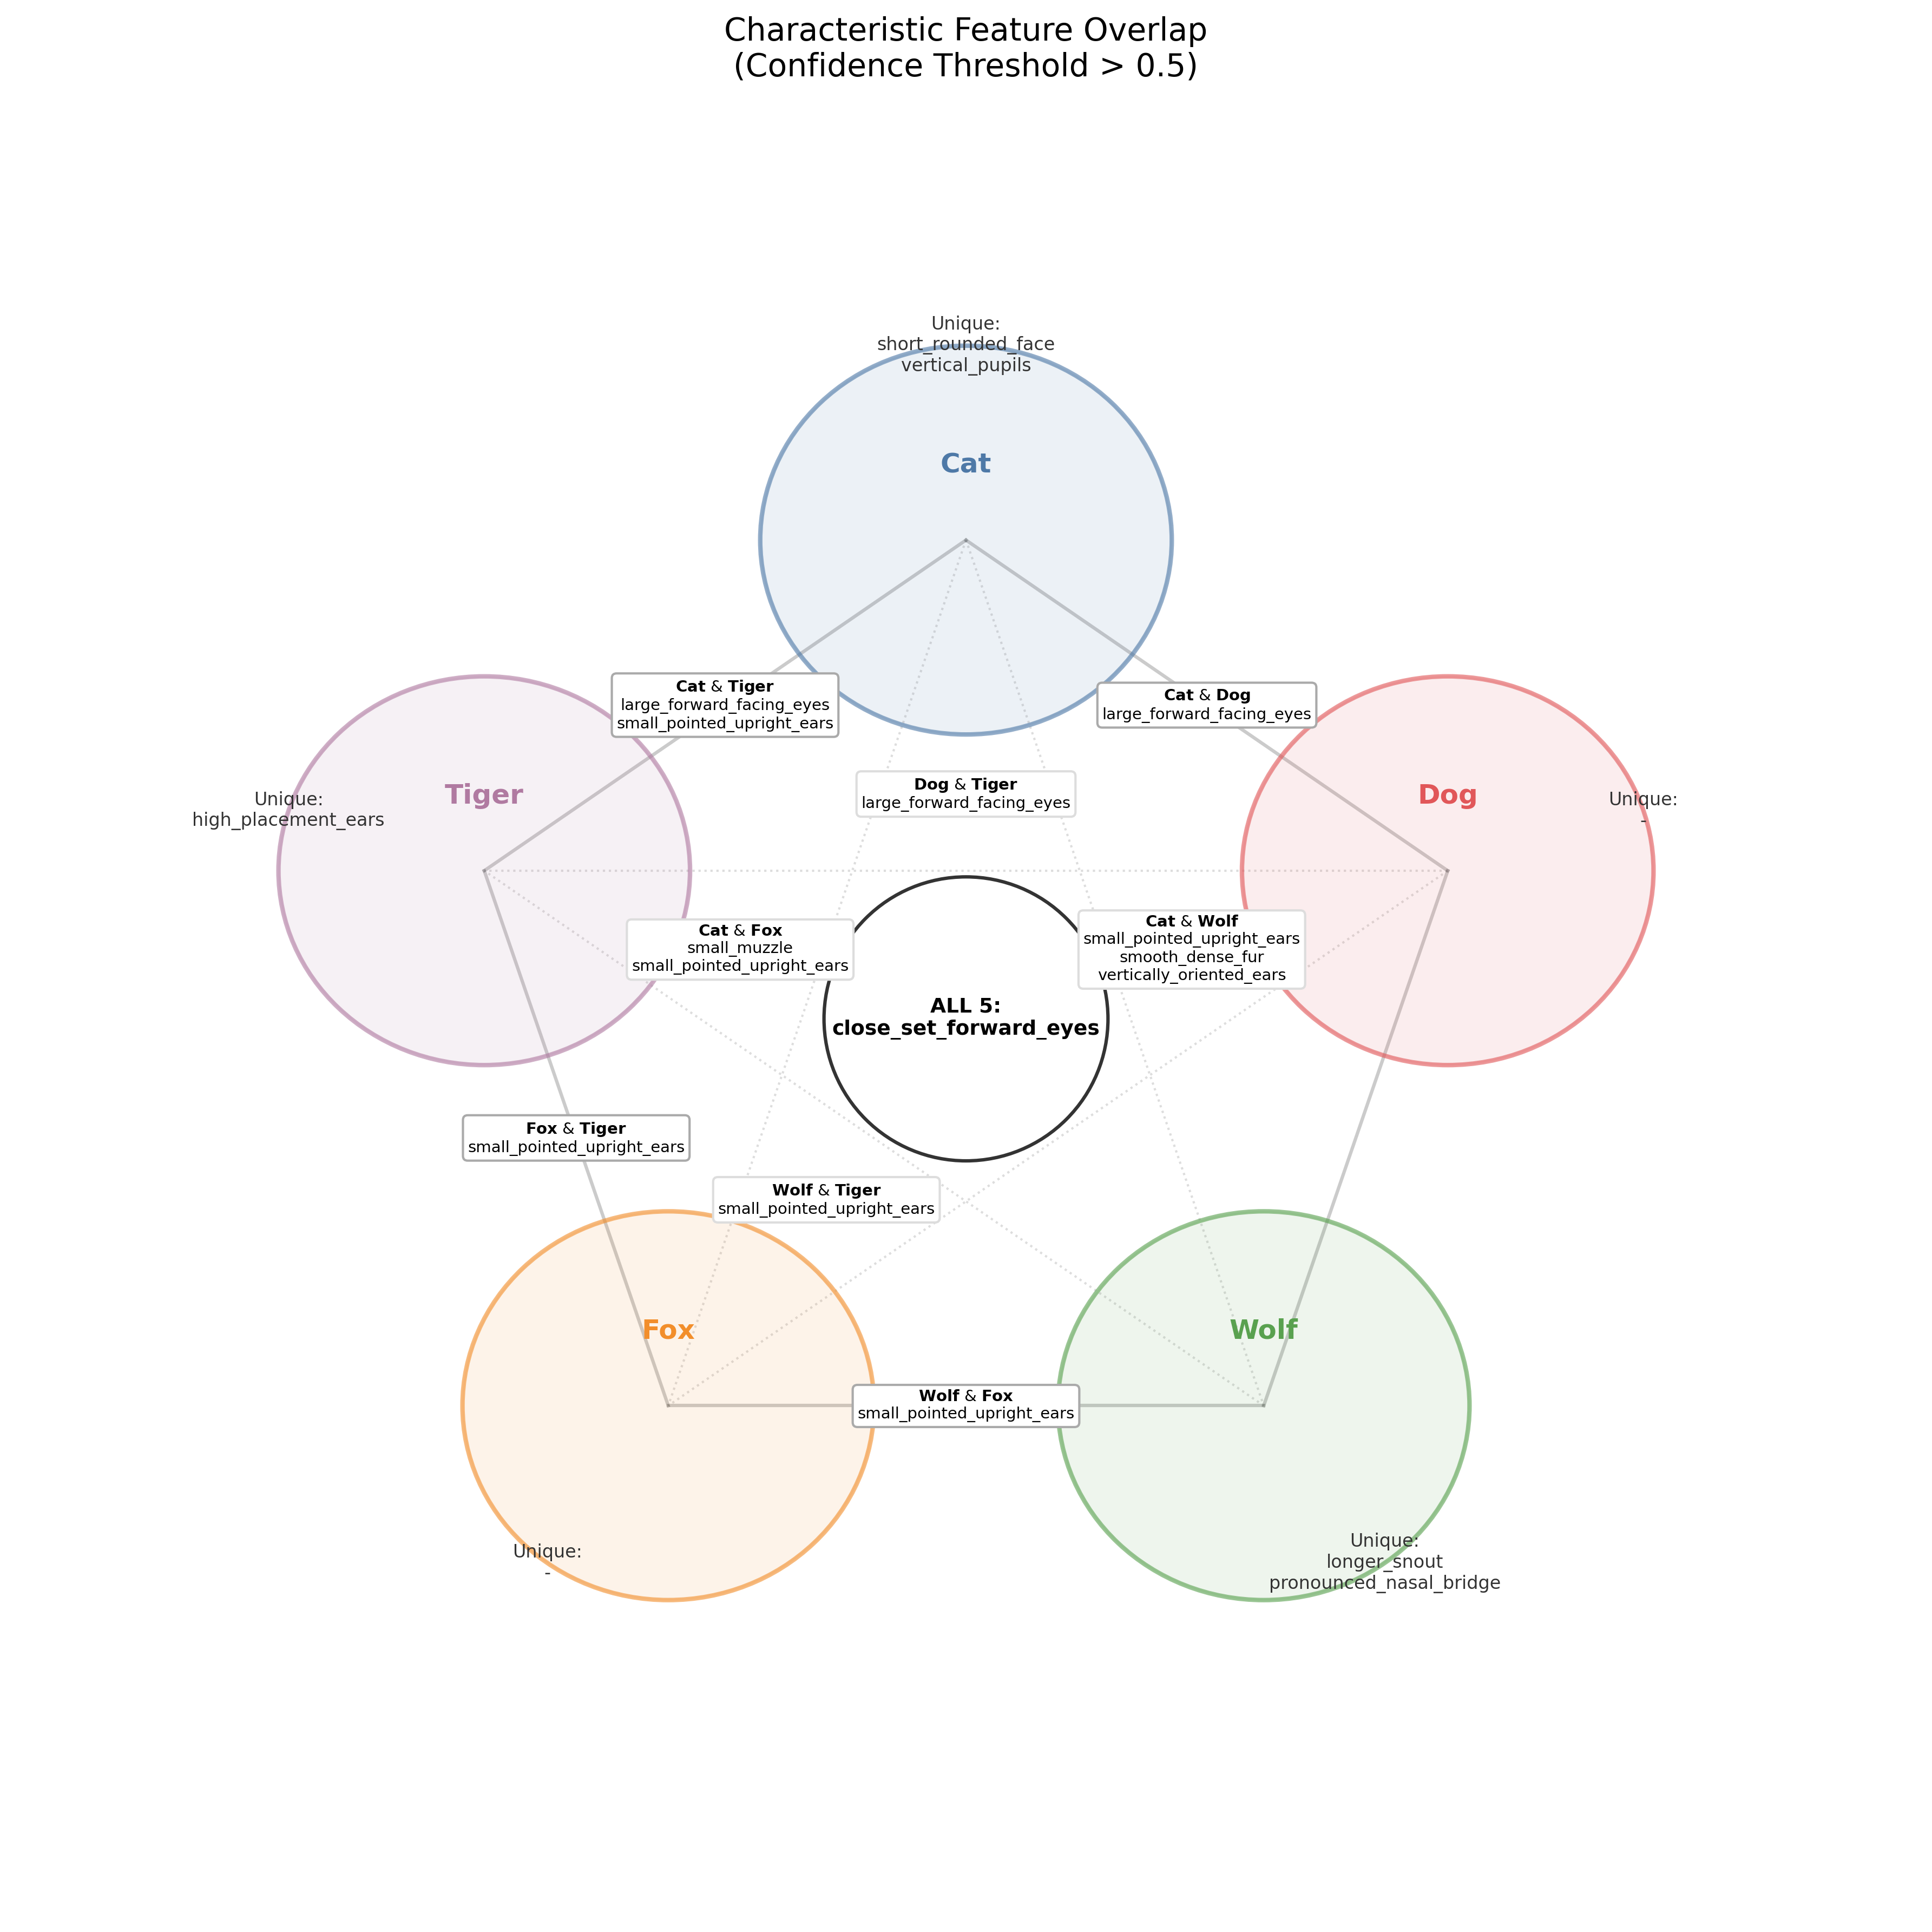

In [3]:
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, FancyBboxPatch
from collections import defaultdict
import math
import itertools

def get_category(image_path):
    """
    Maps specific animals to categories for the Venn Diagram.
    Returns: Cat, Dog, Wolf, Fox, or Tiger
    """
    path_lower = image_path.lower()
    if 'cat' in path_lower:
        return 'Cat'
    elif 'dog' in path_lower:
        return 'Dog'
    elif 'wolf' in path_lower:
        return 'Wolf'
    elif 'fox' in path_lower:
        return 'Fox'
    elif 'tiger' in path_lower:
        return 'Tiger'
    return None

def analyze_and_plot():
    file_path = "./results/experiment/experiment_results.jsonl"
    
    # Stores the sum of probability scores for each feature per category
    feature_stats = defaultdict(lambda: defaultdict(float))
    category_counts = defaultdict(int)

    # 1. Parse Data
    try:
        with open(file_path, 'r') as f:
            for line in f:
                if not line.strip(): continue
                entry = json.loads(line)
                
                category = get_category(entry.get('image_path', ''))
                if not category: continue
                
                category_counts[category] += 1
                grounding = entry.get('grounding_results', {})
                
                for feature, score in grounding.items():
                    feature_stats[category][feature] += score
                    
    except FileNotFoundError:
        print("File not found.")
        return

    # 2. Thresholding
    THRESHOLD = 0.50
    
    features_sets = {
        'Cat': set(),
        'Dog': set(),
        'Wolf': set(),
        'Fox': set(),
        'Tiger': set()
    }
    
    for category in features_sets.keys():
        if category_counts[category] == 0: continue
        for feat, total_score in feature_stats[category].items():
            avg_score = total_score / category_counts[category]
            if avg_score >= THRESHOLD:
                features_sets[category].add(feat)

    # 3. Intersections
    intersection_all = set.intersection(*features_sets.values()) if features_sets['Cat'] else set()

    def get_pairwise_overlap(set_a, set_b, exclude_set):
        return (set_a & set_b) - exclude_set

    # 4. Visualization Setup
    # Research quality styling
    plt.style.use('default') 
    fig, ax = plt.subplots(figsize=(12, 12), dpi=300) 
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.axis('off')

    # Professional Color Palette (Muted/Pastel)
    # Cat (Blue), Dog (Red/Orange), Wolf (Green), Fox (Red), Tiger (Purple)
    colors = {
        'Cat':   '#4E79A7', # Muted Blue
        'Dog':   '#E15759', # Muted Red
        'Wolf':  '#59A14F', # Muted Green
        'Fox':   '#F28E2B', # Muted Orange
        'Tiger': '#B07AA1'  # Muted Purple
    }

    # Categories in clockwise order
    categories = ['Cat', 'Dog', 'Wolf', 'Fox', 'Tiger']
    
    # Calculate geometric positions for a perfect pentagon
    # Center is (0,0)
    radius_circle = 3.2  # Distance from center to node center
    radius_unique = 4.5  # Reduced from 4.8 to bring labels closer to nodes
    node_radius = 1.3    # Increased slightly (1.2 -> 1.3) to fill space better
    
    node_positions = {}
    unique_positions = {}
    
    # Start at 90 degrees (Top)
    start_angle = math.pi / 2
    
    for i, name in enumerate(categories):
        angle = start_angle - (i * 2 * math.pi / 5)
        
        # Node Center
        cx = radius_circle * math.cos(angle)
        cy = radius_circle * math.sin(angle)
        node_positions[name] = (cx, cy)
        
        # Unique Text Position
        ux = radius_unique * math.cos(angle)
        uy = radius_unique * math.sin(angle)
        unique_positions[name] = (ux, uy)

    # Helper to format text
    def format_features(feature_set):
        if not feature_set: return "-"
        lst = sorted(list(feature_set))
        return "\n".join(lst)

    # A. Draw Nodes (Circles) & Unique Features
    for name in categories:
        pos = node_positions[name]
        color = colors[name]
        
        # Draw Circle
        circle = Circle(pos, node_radius, alpha=0.1, color=color, zorder=1)
        ax.add_patch(circle)
        
        # Draw Circle Border
        circle_border = Circle(pos, node_radius, fill=False, edgecolor=color, linewidth=2, alpha=0.6, zorder=2)
        ax.add_patch(circle_border)
        
        # Label (Title of Animal)
        ax.text(pos[0], pos[1] + 0.5, name, fontsize=12, fontweight='bold', 
                ha='center', va='center', color=color, zorder=5)
        
        # Unique Features
        others = set()
        for other_name, other_set in features_sets.items():
            if other_name != name:
                others.update(other_set)
        
        unique_set = features_sets[name] - others
        unique_text = format_features(unique_set)
        
        # Place Unique Text
        u_pos = unique_positions[name]
        ax.text(u_pos[0], u_pos[1], f"Unique:\n{unique_text}", 
                ha='center', va='center', fontsize=8, color='#333333',
                bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'))

    # B. Draw Pairwise Connections (Lines & Overlaps)
    pairs = list(itertools.combinations(categories, 2))
    
    for name_a, name_b in pairs:
        idx_a = categories.index(name_a)
        idx_b = categories.index(name_b)
        
        pos_a = node_positions[name_a]
        pos_b = node_positions[name_b]
        
        # Determine relationship type
        diff = abs(idx_a - idx_b)
        is_adjacent = (diff == 1) or (diff == 4)
        
        # Line Style
        line_style = '-' if is_adjacent else ':'
        line_alpha = 0.3 if is_adjacent else 0.2
        line_width = 1.5 if is_adjacent else 1.0
        line_color = '#555555'
        
        # Draw connecting line
        ax.plot([pos_a[0], pos_b[0]], [pos_a[1], pos_b[1]], 
                color=line_color, linestyle=line_style, alpha=line_alpha, linewidth=line_width, zorder=0)
        
        # Calculate Overlap
        overlap = get_pairwise_overlap(features_sets[name_a], features_sets[name_b], intersection_all)
        
        if overlap:
            text_features = format_features(overlap)
            text_content = f"$\\mathbf{{{name_a}}}$ & $\\mathbf{{{name_b}}}$\n{text_features}"
            
            # Midpoint
            mid_x = (pos_a[0] + pos_b[0]) / 2
            mid_y = (pos_a[1] + pos_b[1]) / 2
            
            # Fix overlap for diagonal pairs: push labels outwards from center
            if not is_adjacent:
                dist_from_center = math.sqrt(mid_x**2 + mid_y**2)
                if dist_from_center > 0:
                    # Push to radius ~1.5. 
                    # Center circle is 0.7. Node edge is 3.2-1.3=1.9. 
                    # 1.5 is safely in the middle.
                    scale_factor = 1.5 / dist_from_center
                    mid_x *= scale_factor
                    mid_y *= scale_factor
            
            # Background box color
            box_bg = '#FFFFFF'
            border_color = '#AAAAAA' if is_adjacent else '#DDDDDD'
            
            # ZORDER = 30 ensures this sits ON TOP of the central circle
            ax.text(mid_x, mid_y, text_content, 
                    ha='center', va='center', fontsize=7, zorder=30,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor=box_bg, 
                              edgecolor=border_color, alpha=1.0))

    # C. Global Intersection (Center)
    shared_text = format_features(intersection_all)
    
    # Center Node (All 5)
    # Reduced radius to 0.7 for more room
    center_circle = Circle((0,0), 0.7, color='#333333', alpha=0.05, zorder=20)
    ax.add_patch(center_circle)
    
    ax.text(0, 0, f"ALL 5:\n{shared_text}", 
            ha='center', va='center', fontsize=9, fontweight='bold', zorder=25,
            bbox=dict(boxstyle="circle,pad=0.4", facecolor='white', edgecolor='#333333', linewidth=1.5))

    # Title
    plt.title(f"Characteristic Feature Overlap\n(Confidence Threshold > {THRESHOLD})", fontsize=14, pad=20)
    
    plt.tight_layout()
    plt.savefig('feature_set_diagram.png')
    
    print("Graph generated: feature_set_diagram.png")
    print("-" * 30)
    print(f"Common to ALL: {', '.join(sorted(list(intersection_all)))}")

if __name__ == "__main__":
    analyze_and_plot()

In [7]:
import json
import os
import math
import random
from PIL import Image

def create_collage():
    jsonl_path =  "./results/experiment/experiment_results.jsonl"
    output_filename = 'experiment_collage_heatmaps.jpg'
    
    # Grid configuration
    cols = 4
    rows = 4
    thumb_size = (200, 200)  # Size of each tile in the collage
    
    # 1. Extract Image Paths
    image_paths = []
    try:
        with open(jsonl_path, 'r') as f:
            for line in f:
                if not line.strip(): continue
                entry = json.loads(line)
                path = entry.get('image_path')
                if path:
                    image_paths.append(path)
    except FileNotFoundError:
        print(f"Error: Could not find {jsonl_path}")
        return

    # Randomize the selection
    random.shuffle(image_paths)

    # Limit to 49 images for a 7x7 grid
    max_images = cols * rows
    if len(image_paths) > max_images:
        print(f"Found {len(image_paths)} images. Selecting {max_images} random images for the {cols}x{rows} grid.")
        image_paths = image_paths[:max_images]
    else:
        print(f"Found {len(image_paths)} images.")

    # 2. Create Blank Canvas
    collage_width = cols * thumb_size[0]
    collage_height = rows * thumb_size[1]
    collage_image = Image.new('RGB', (collage_width, collage_height), color=(255, 255, 255))

    # 3. Populate Collage
    print("Generating collage...")
    for index, original_path in enumerate(image_paths):
        # Calculate position
        col_idx = index % cols
        row_idx = index // cols
        x = col_idx * thumb_size[0]
        y = row_idx * thumb_size[1]

        # Construct Heatmap Path
        # Logic: collage/dogs/dog008.jpg -> results/experiment/layer_cam/dog008_layercam.png
        filename = os.path.basename(original_path)
        name, _ = os.path.splitext(filename)
        heatmap_filename = f"{name}_layercam.png"
        heatmap_path = os.path.join("results/experiment/layer_cam", heatmap_filename)

        try:
            # Check if file exists to prevent crash
            if not os.path.exists(heatmap_path):
                print(f"Warning: Heatmap not found at {heatmap_path}, skipping.")
                continue
                
            with Image.open(heatmap_path) as img:
                # Resize keeping aspect ratio, then center crop (thumbnail behavior)
                img = img.convert('RGB')
                
                # Smart resize (crop to fit)
                img_ratio = img.width / img.height
                target_ratio = thumb_size[0] / thumb_size[1]
                
                if img_ratio > target_ratio:
                    # Too wide: match height, crop width
                    new_height = thumb_size[1]
                    new_width = int(new_height * img_ratio)
                    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
                    left = (img.width - thumb_size[0]) / 2
                    img = img.crop((left, 0, left + thumb_size[0], thumb_size[1]))
                else:
                    # Too tall: match width, crop height
                    new_width = thumb_size[0]
                    new_height = int(new_width / img_ratio)
                    img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
                    top = (img.height - thumb_size[1]) / 2
                    img = img.crop((0, top, thumb_size[0], top + thumb_size[1]))

                collage_image.paste(img, (x, y))
                
        except Exception as e:
            print(f"Error processing {heatmap_path}: {e}")

    # 4. Save Result
    collage_image.save(output_filename)
    print(f"Collage saved as {output_filename}")

if __name__ == "__main__":
    create_collage()

Found 66 images. Selecting 16 random images for the 4x4 grid.
Generating collage...
Collage saved as experiment_collage_heatmaps.jpg
